## Output has been removed from this notebook to reduce file sizes in the repo

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
import geopandas.io.osm as osm
%matplotlib inline

C:\Users\spm448\Anaconda\DLLs


## Download OpenStreetMap restaurants for a good part of the Bay Area

###### Note: used http://boundingbox.klokantech.com/ to get the bounding box

In [2]:
gdf = osm.query_osm('node', 
                    bbox=[-122.5231,37.7056,-122.3805,37.8123],
                    tags='amenity=fast_food')
print len(gdf)

131


In [3]:
gdf = gdf[gdf.type == 'Point'].to_crs(epsg=3740)
print gdf.geometry.head(3)
print len(gdf)

0    POINT (553308.7747792731 4181596.862642631)
1     POINT (546156.4732378857 4175586.26882281)
2    POINT (553423.8610956167 4183304.596048915)
Name: geometry, dtype: object
131


In [4]:
x, y = zip(*[(p.x, p.y) for (i, p) 
             in gdf.geometry.iteritems()])
x = pd.Series(x)
y = pd.Series(y)

## Get OpenStreetMap networks for Bay Area that I had previously - someday soon we'll have direct OSM import

In [5]:
store = pd.HDFStore('data/osm_bayarea.h5', "r")
nodes = store.nodes
edges = store.edges
print nodes.head(3)
print edges.head(3)

              x           y
8   629310.1250  4095536.75
9   629120.9375  4095816.75
10  628951.5625  4096090.50
   from  to      weight
6     8   9  338.255005
7     9  10  322.532990
8    10  11  218.505997


## Initialize and preprocess the network

In [6]:
net=pdna.Network(nodes.x, 
                       nodes.y, 
                       edges["from"], 
                       edges.to, 
                       edges[["weight"]])
net.precompute(3000)

## Nearest *point-of-interest* queries

In [7]:
net.init_pois(num_categories=1, max_dist=3000, max_pois=10)

In [8]:
net.set_pois("fast_foods", x, y)

In [9]:
a = net.nearest_pois(3000, "fast_foods", num_pois=10)
a_df = pd.DataFrame(a[1])
print a_df.head(1)

      1
8  3000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C9E9390>]], dtype=object)

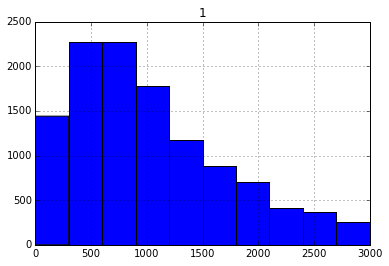

In [10]:
a_df[a_df[1]!= 3000].hist()

In [30]:
b = net.aggregate(3000, type="ave", decay="flat")

In [34]:
b_df = pd.DataFrame(b)
print b_df

        0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
39      0
51      0
52      0
53      0
55      0
56      0
57      0
58      0
60      0
61      0
62      0
63      0
64      0
...    ..
354665  1
354668  0
354669  0
354670  0
354671  0
354672  0
354673  0
354674  0
354675  0
354676  0
354677  0
354678  0
354679  0
354680  0
354681  0
354682  0
354683  0
354684  0
354685  0
354686  0
354687  0
354688  0
354689  0
354690  0
354691  0
354692  0
354693  0
354694  0
354695  0
354696  0

[226060 rows x 1 columns]


In [12]:
from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas as gpd
bbox=[-122.539365,37.693047,-122.347698,37.816069]
bbox = gpd.GeoSeries([Point(bbox[0], bbox[1]),
                      Point(bbox[2], bbox[3])], 
                     crs=from_epsg(4326))
bbox = bbox.to_crs(epsg=3740)
bbox = [bbox[0].x, bbox[0].y, bbox[1].x, bbox[1].y]

## Here's a map of the distance to the nearest restaurant

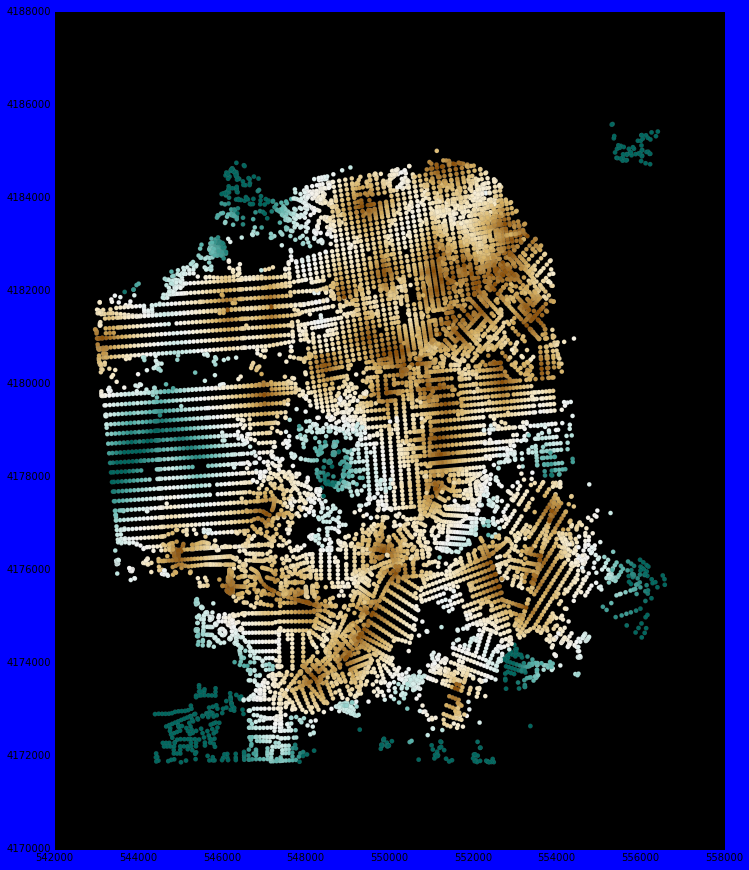

In [13]:
net.plot(a[1], bbox=bbox, scheme="diverging", 
         color="BrBG")

## Here's a map of the distance to the 5th nearest restaurant

In [ ]:
net.plot(a[5], bbox=bbox, scheme="diverging", 
         color="BrBG")

## Here's a map of the distance to the 10th nearest restaurant

In [ ]:
net.plot(a[10], bbox=bbox, scheme="diverging", 
         color="BrBG")

# A similar workflow is used to do general network aggregations

## Relate the x-ys to nodes

In [15]:
node_ids = net.get_node_ids(x, y)

## Assign the variable (in this case just location) to the network

In [16]:
net.set(node_ids)

## This is it - run the queries!

In [17]:
%time s = net.aggregate(500, type="sum", decay="linear")
%time t = net.aggregate(1000, type="sum", decay="linear")
%time u = net.aggregate(2000, type="sum", decay="linear")
%time v = net.aggregate(3000, type="sum", decay="linear")
%time w = net.aggregate(3000, type="count", decay="flat")

Wall time: 220 ms
Wall time: 258 ms
Wall time: 492 ms
Wall time: 13.2 s
Wall time: 13.2 s


In [ ]:
# Let's do some data analysis

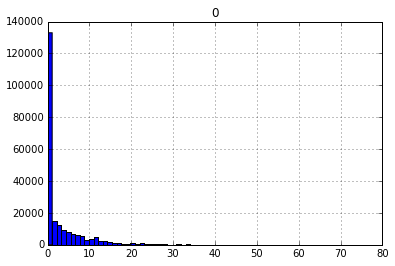

In [33]:
t_df = pd.DataFrame(w)
t_hist = t_df.hist(bins=70)

## Here's a map of access to restaurants with a 500m radius

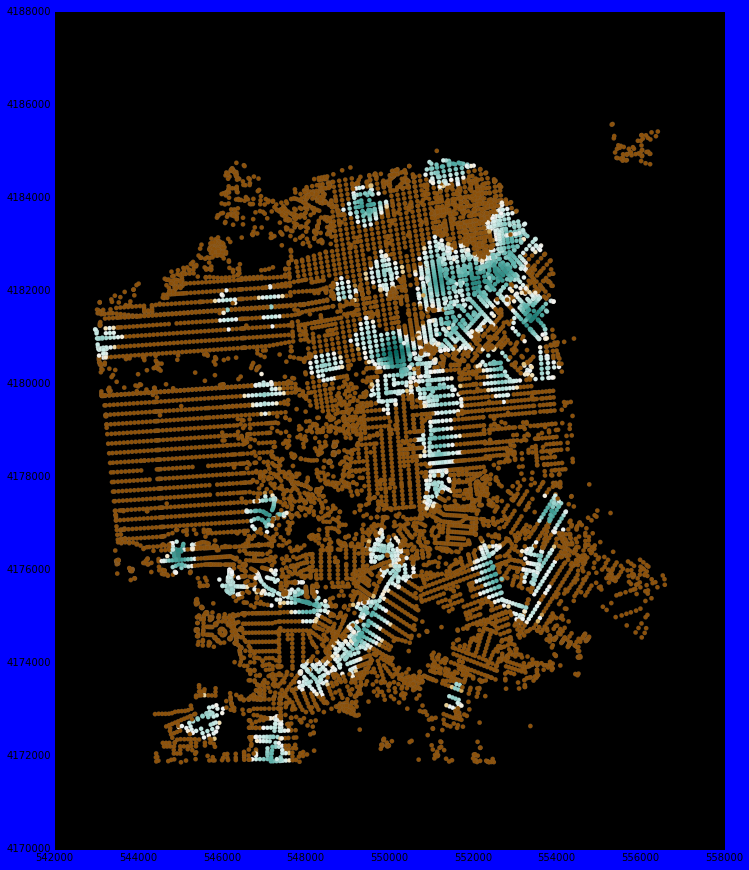

In [18]:
net.plot(s, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or 1000 meters

In [ ]:
net.plot(t, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or 2000 meters radius

In [ ]:
net.plot(u, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or 3000m radius

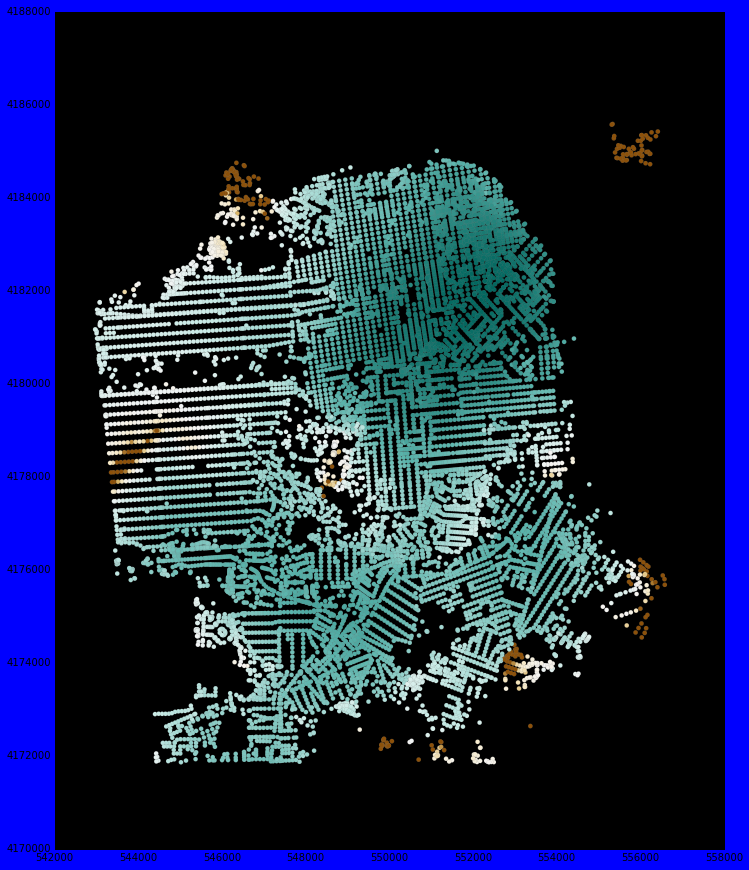

In [19]:
net.plot(v, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or the whole Bay Area region - someone please help me with this visualization!

In [ ]:
net.plot(v, scheme="diverging", 
         color="BrBG", log_scale=True)